In [1]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil

In [3]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()

if cur_system == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path

    # Directories for current working session. These need to be set manually.
    basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone')
    
    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
    plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots/Stb_Silverstone')

elif cur_system == "Windows":   # For Windows
    sys.path.extend(['C:\\BrianKim\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    
    # Directories for current working session. These need to be set manually.
    #basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1')
    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots')

In [4]:
# Import NeuroPy Packages

# Analyses
from neuropy.analyses import oscillations
from neuropy.analyses.spkepochs import detect_pbe_epochs

# Core
from neuropy import core

from neuropy.core import Epoch
from neuropy.core import Neurons
from neuropy.core.neurons import binned_pe_raster
from neuropy.core.neurons import pe_raster

from neuropy.core import BinnedSpiketrain
from neuropy.core import Shank, Probe, ProbeGroup

from neuropy.core.session import ProcessData

# IO
from neuropy.io import PhyIO

from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.io.openephysio import load_all_ttl_events

# Plotting
from neuropy.plotting import plot_probe
from neuropy.plotting import Fig
from neuropy.plotting import spikes

from neuropy.plotting.signals import plot_signal_traces

# Utils

from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.utils.signal_process import filter_sig

In [5]:
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

signal = sess.eegfile.get_signal()
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3405.69 seconds 
duration: 0.95 hours 

Existing artifact epochs file loaded


/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.probegroup.npy saved


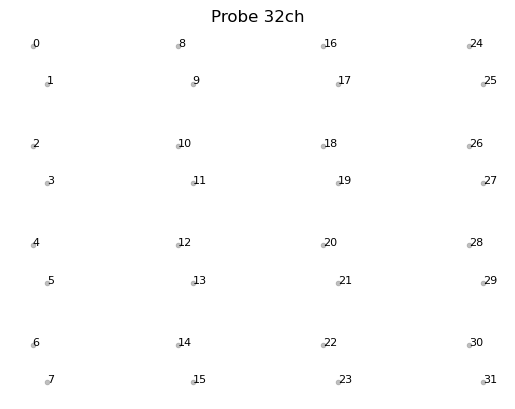

In [6]:
# Set Probe Configuration
shanks = []
channel_groups = sess.recinfo.channel_groups

for i in range(4):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=4,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]),
    )
    shanks.append(shank)
    #shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks,shank_pitch=(150,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
plot_probe(prbgrp)
sess.prbgrp = prbgrp


In [7]:
# Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

for sh in np.unique(sess.neurons.shank_ids.astype(int)):
    sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [10]:
stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")


stim_epochs = Epoch(epochs=None, file=stim_epochs_file)
stim_epochs_df = stim_epochs.to_dataframe()
pd.set_option('display.max_rows', None)
stim_epochs_df 

,start,stop,duration,time_between,label
0,474.496467,474.546467,0.050000,NaN,
1,474.552767,474.602733,0.049967,0.006300,
2,474.644567,474.694567,0.050000,0.041833,
3,474.738100,474.788100,0.050000,0.043533,
4,474.832733,474.882733,0.050000,0.044633,
5,474.939867,474.989867,0.050000,0.057133,
6,475.031233,475.081233,0.050000,0.041367,
7,475.139567,475.189567,0.050000,0.058333,
8,475.233767,475.283767,0.050000,0.044200,
9,475.342133,475.392133,0.050000,0.058367,


In [21]:
final_test_stim = 191
test_stim_epochs_df = stim_epochs_df.head(final_test_stim).copy()

s_label = []
total_stims = test_stim_epochs_df.shape[0]
t_num = 1
for i in range(0, total_stims):
    if test_stim_epochs_df.loc[i,'time_between'] > 1:
        t_num = t_num + 1
    s_label.append(t_num)
test_stim_epochs_df['label'] = pd.Series(s_label)

# Split epochs into stim events
t_starts = test_stim_epochs_df.groupby('label')['start'].first().to_numpy()
test_stim_epochs_df

,start,stop,duration,time_between,label
0,474.496467,474.546467,0.050000,NaN,1
1,474.552767,474.602733,0.049967,0.006300,1
2,474.644567,474.694567,0.050000,0.041833,1
3,474.738100,474.788100,0.050000,0.043533,1
4,474.832733,474.882733,0.050000,0.044633,1
5,474.939867,474.989867,0.050000,0.057133,1
6,475.031233,475.081233,0.050000,0.041367,1
7,475.139567,475.189567,0.050000,0.058333,1
8,475.233767,475.283767,0.050000,0.044200,1
9,475.342133,475.392133,0.050000,0.058367,1


It is advisable to use this estimation across multiple neurons object


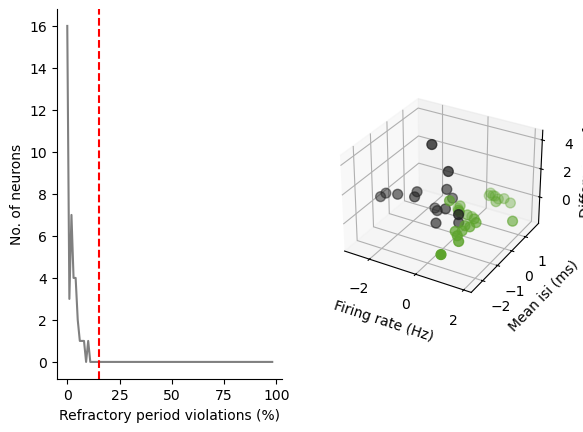

In [22]:
ce_classification = neurons_util.estimate_neuron_type(sess.neurons, mua_thresh=15)
ce_classification = ce_classification[0]

In [23]:
for i in range(0, len(sess.neurons)):
    
    # Test for 20hz pulse plot
    b_size = 0.25
    pulse_dur = 0.05
    pulse_freq = 10
    pulse_int = 1 / pulse_freq  # Time between the start of each pulse
    sid = int(sess.neurons.shank_ids[i])
    
    if sess.neurons.clu_q[i] <= 3:
        c_class = "pyr"
    elif sess.neurons.clu_q[i] == 6:
        c_class = "mua"
    elif sess.neurons.clu_q[i] == 8:
        c_class = "int"
    else:
        c_class = "noise"
    
    pulse_plot, ax = plt.subplots(1,1)
    pulse_plot.set_size_inches([12,6]) # Adjust the width and height to make it wider
    
    # Create Pulse Plot
    t_cell = pe_raster(neurons=sess.neurons, neuron_id=i, event_times=t_starts, buffer_sec=(1,2))
    spikes.plot_raster(t_cell, ax=ax, markersize=6)
    
    
    # Add blue shaded regions from 0s to 1s to indicate optogenetic pulses
    for start_time in range(pulse_freq):
        pulse_start = start_time * pulse_int
        pulse_end = pulse_start + pulse_dur
        ax.axvspan(pulse_start, pulse_end, color='blue', alpha=0.2)

    # Add title
    plt.suptitle(f'Cell {i} (Loc: S{sid}) 10Hz Stims', fontsize=14, y=1.05)
    ax.set_ylabel("Trials")
    
    ax1 = ax.twinx()
    
    
    t_fr = t_cell.get_binned_spiketrains(bin_size=b_size)
    t_binned_averages = t_fr.spike_counts.mean(axis=0)
    t_binned_stds = t_fr.spike_counts.std(axis=0)
    n_trials = t_fr.spike_counts.shape[0]
    t_binned_sems = t_binned_stds / np.sqrt(n_trials)
    
    x_values = np.linspace(-1, 2, len(t_binned_averages))
    ax1.plot(x_values, t_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax1.set_ylabel('Firing Rate(Hz)')
    ax1.set_ylim(0, 30) 
    ax1.fill_between(x_values, t_binned_averages - t_binned_sems, t_binned_averages + t_binned_sems, color='red', alpha=0.3)
    
    
    pulse_plot.text(0.65, 0.93, f'Cell Classification: {ce_classification[i]}', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    ax1.legend()
    ax1.legend(loc='upper left', bbox_to_anchor=(0,1.35))
    
    
    
    plot_name = f'PulseStim_Cell_{i}_S{sid}.png' 
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()